# Huggingface Sagemaker-sdk - Getting Started Demo
### Binary Classification with `Keras` and `imdb` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end binary Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on binary text classification. In particular, the pre-trained model will be fine-tuned using the `imdb` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

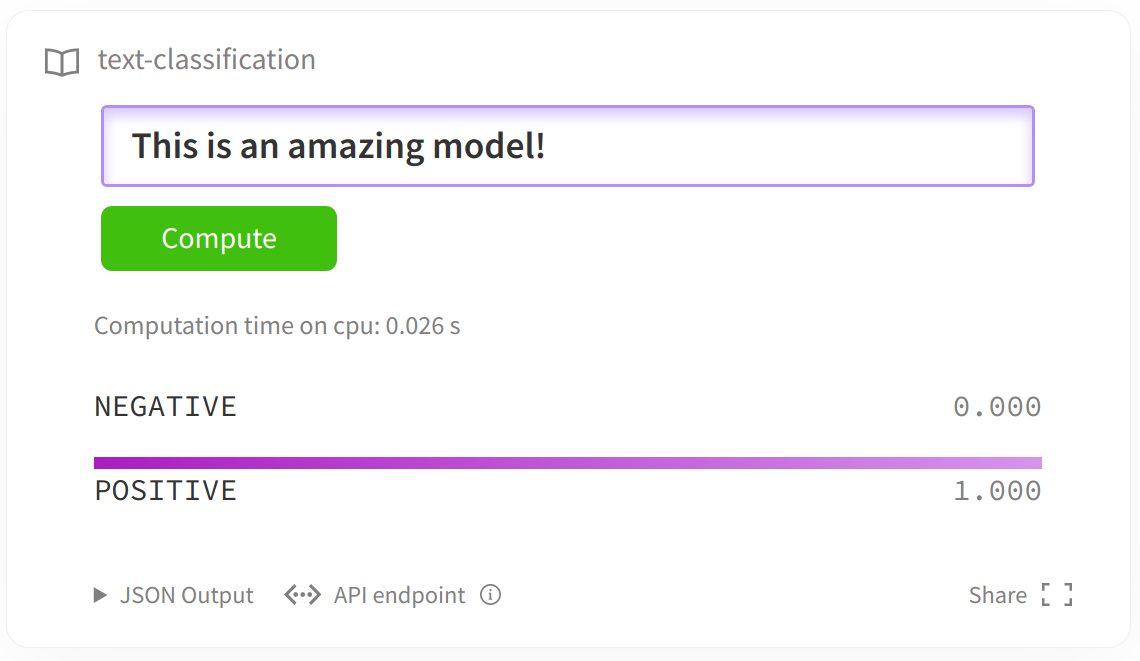

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [1]:
!pip install "sagemaker>=2.31.0" "transformers>=4.4.2" "datasets[s3]>=1.5.0" --upgrade

     |████████████████████████████████| 2.2 MB 25.5 MB/s eta 0:00:01     |███████████████████████▋        | 1.7 MB 25.5 MB/s eta 0:00:01
     |████████████████████████████████| 221 kB 39.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 61.2 MB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.43
    Uninstalling botocore-1.19.43:
      Successfully uninstalled botocore-1.19.43
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.9
    Uninstalling huggingface-hub-0.0.9:
      Successfully uninstalled huggingface-hub-0.0.9
  Attempting uninstall: datasets
    Found existing installation: datasets 1.5.0
    Uninstalling datasets-1.5.0:
      Successfully uninstalled datasets-1.5.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.4.2
    Uninstalling transformers-4.4.2:
      Successfully uninstalled transformers-4.4.2
ERROR: pip's dependency resolver do

## Development environment 

**upgrade ipywidgets for `datasets` library and restart kernel, only needed when prerpocessing is done in the notebook**

In [2]:
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
IPython.Application.instance().kernel.do_shutdown(True) # has to restart kernel so changes are used

In [2]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [3]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::367158743199:role/service-role/AmazonSageMaker-ExecutionRole-20210413T121296
sagemaker bucket: sagemaker-us-east-1-367158743199
sagemaker session region: us-east-1


# Preprocessing

In this example the preproccsing will be done in the `train.py` when executing the script. You could also move the `preprocessing` outside of the script and upload the data to s3 and pass it into it.

# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py37',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local-gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [2]:
!pygmentize ./scripts/train.py

import argparse
import logging
import os
import sys

import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # Hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train-batch-size", type=int, default=16)
    parser.add_argument("--eval-batch-size", type=int, default=8)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)
    parser.add_argument("--do_train", type=bool, default=True)
    parser.add_argument("--do_eval", type=bool, default=True)

    # Data, model, and output directories
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODE

## Creating an Estimator and start a training job

In [4]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 16,
                 'model_name':'distilbert-base-uncased'
                }

In [5]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.4',
                            tensorflow_version='2.4',
                            py_version='py37',                                   
                            hyperparameters = hyperparameters)

In [6]:
huggingface_estimator.fit()

2021-05-25 17:00:51 Starting - Starting the training job...
2021-05-25 17:01:15 Starting - Launching requested ML instancesProfilerReport-1621962051: InProgress
......
2021-05-25 17:02:15 Starting - Preparing the instances for training.........
2021-05-25 17:03:52 Downloading - Downloading input data
2021-05-25 17:03:52 Training - Downloading the training image..................
2021-05-25 17:06:52 Training - Training image download completed. Training in progress..2021-05-25 17:06:53.348122: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-05-25 17:06:53.353623: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-05-25 17:06:53.477678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-25 17:06:53.581995: W tensorflow

## Estimator Parameters

In [12]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")


container image used for training job: 
None

s3 uri where the trained model is located: 
s3://sagemaker-us-east-1-367158743199/huggingface-tensorflow-training-2021-05-25-17-00-51-363/output/model.tar.gz

latest training job name for this estimator: 
huggingface-tensorflow-training-2021-05-25-17-00-51-363



In [9]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2021-05-25 17:22:20 Starting - Preparing the instances for training
2021-05-25 17:22:20 Downloading - Downloading input data
2021-05-25 17:22:20 Training - Training image download completed. Training in progress.
2021-05-25 17:22:20 Uploading - Uploading generated training model
2021-05-25 17:22:20 Completed - Training job completed2021-05-25 17:06:53.348122: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-05-25 17:06:53.353623: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-05-25 17:06:53.477678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-25 17:06:53.581995: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-05-25 17:06:57,817 sagemaker-training-tool

## Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [13]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name = huggingface_estimator.latest_training_job.name

In [14]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data


2021-05-25 17:22:20 Starting - Preparing the instances for training
2021-05-25 17:22:20 Downloading - Downloading input data
2021-05-25 17:22:20 Training - Training image download completed. Training in progress.
2021-05-25 17:22:20 Uploading - Uploading generated training model
2021-05-25 17:22:20 Completed - Training job completed


's3://sagemaker-us-east-1-367158743199/huggingface-tensorflow-training-2021-05-25-17-00-51-363/output/model.tar.gz'

In [15]:
huggingface_estimator_loaded